**Задача**: 

Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара.

Существует два вида таких отзывов:

- положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
- отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.

**Данные**

Cписок размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)

**Результат**

Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.

**задача :** проработка и формализация задачи, определение таргета


**итог работы:** определен таргет, определена мл задача

**Таргет** -  тагетом является - 'label'

**мл задача** - бинарный классификатор

**План проекта**

1.Понимание бизнес-проблемы

2.Изучение данных и ознакомление с ними(Изучение содержимого файлов, предварительная обработка для удобства дальнейшей работы.)

3.Подготовка данных к моделированию посредством обнаружения резко отклоняющихся значений, преобразования переменных, обработки пропущенных значений,Определение целевого признака.Кодирование признаков.Удаление ненужных признаков.Разбиение данных на выборки.
 Агрегрирование и объединение таблиц. Изучение целевого признака.

4.определить, что является для нас ключевой метрикой, к каким показателям качества стремиться;

5.подготовить несколько моделей машинного обучения (и анализ результата для внесения соответствующих изменений,выбираем лучшую модель на кросс-валидации)- разработать бинарный классификатор;  

6.Проверка модели с использованием нового набора данных(тестовый набор данных)

7.предоставить полноценный отчет с рекомендациями для бизнеса.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.ensemble import RandomForestClassifier


import re




import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('wordnet')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 1234567

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data =  pd.read_csv('/content/drive/MyDrive/wb/wb_school_task_2.csv')

In [ ]:
data.head()


,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


In [ ]:
def show_rows(data_frame):
    rows_count, columns_count = data_frame.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    for column in data_frame.columns:
        print('Количество пропусков в каждом столбце')    
        print(data_frame.isna().sum())

In [ ]:
 show_rows(data)

Количество стобцов: 13
Количество строк: 3123
Количество пропусков в каждом столбце
id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64
Количество пропусков в каждом столбце
id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64
Количество пропусков в каждом столбце
id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64
Количество пропусков в каждом столбце
id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64
Количество пропусков в каждом столбце
id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label   

*Комментарий:* Пропуски отсутствуют. Стоит проверить количество уникальных элементов для следующих признаков:'id1','id2','id3'. Для того чтобы понять, а какой id является id - пользователя 

In [ ]:
data[['id1','id2','id3']].nunique()

id1    3049
id2    3006
id3     978
dtype: int64

*Комментарий:* Id3 -больше похоже на id пользователя.Так один пользователь может оставлять отзывы на различные товары. Следовательно остальные id можно удалить

In [ ]:
df = data.drop(['id1','id2'],axis =1)

In [ ]:
df

,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...
3118,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


*Комментарий:* Теперь проверим баланс признаков - label

In [ ]:
df['label'].value_counts()

0    2298
1     825
Name: label, dtype: int64

*Комментарий:*Построим диаграмму для лучшей визуализации

<Axes: >

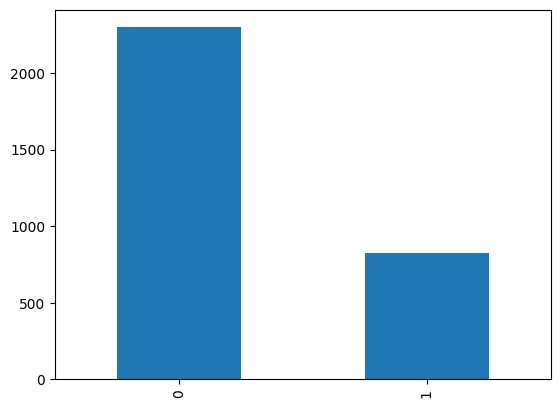

In [ ]:
df['label'].value_counts().plot.bar()

*Комментарий:* Из графика видно, что присутствует сильный дисбаланс классов 

In [ ]:

user_target =df.groupby('id3')['label'].mean()

In [ ]:
user_target

id3
27166662291578269       0.000000
75505668647254912       0.111111
89524856874974827       0.200000
93185620928058855       0.000000
96661188109325683       0.500000
                          ...   
18395955373568991147    1.000000
18417348117660323250    0.000000
18427686369090007398    0.333333
18439416307427740033    1.000000
18444296891091659546    0.333333
Name: label, Length: 978, dtype: float64

<Axes: >

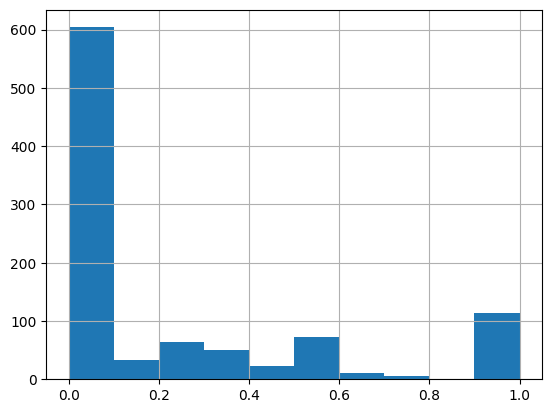

In [ ]:

user_target.hist()

*Комментарий:* Из графика видно, что окола 158 пользователей пишут фейковые отзывы 

In [ ]:
fake_users = user_target.loc[user_target==1].index.to_list()

In [ ]:
df.loc[df['id3'].isin(fake_users)]

,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
1,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
13,5470748928248412803,"Доставка-скорость света! Отличная ёмкость, каж...",35,34,4.571429,18,1,4.833333,44,50,1
23,5576082564072164535,︎ ︎ ︎ ︎ ︎ ︎,8,7,5.000000,96,27,4.520833,12,13,1
60,7610598891996405620,К камню претензий нет. Неограненный берилл. Вс...,59,44,4.576271,2,2,3.500000,82,120,1
63,3167186606958567184,Классная вещь.,5,2,5.000000,100,18,5.000000,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2916,7825013314613369623,Спасибо большое.,1,1,5.000000,23,2,4.260870,2,3,1
2924,10161588360784006515,"качество пленки классное, пользоваться удобно",3,3,5.000000,1312,242,4.911585,15,20,1
2933,11181794830612897654,Товар пришел разбитым. Возврат не приняли. По ...,8,8,4.000000,74,23,3.972973,55,62,1
2948,7022523323558376342,"Бомбическая штука,аромат супер не стягивает кожу",31,30,4.516129,482,45,4.533195,46,57,1


*Комментарий:* 

In [ ]:
feats_corr = df[['f1','f2','f3','f4','f5','f6','f7','f8']].corr()

<Axes: >

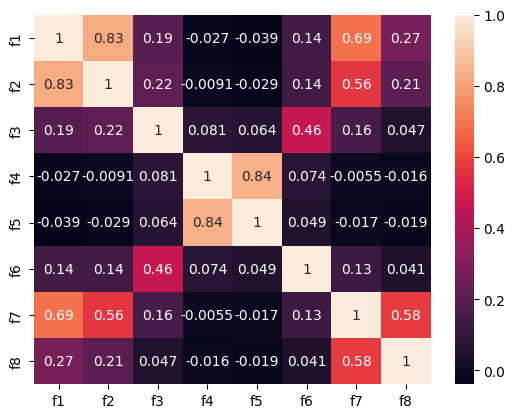

In [ ]:
sns.heatmap(feats_corr, annot = True,fmt='.2g')

array([[<Axes: title={'center': 'f1'}>, <Axes: title={'center': 'f2'}>,
        <Axes: title={'center': 'f3'}>],
       [<Axes: title={'center': 'f4'}>, <Axes: title={'center': 'f5'}>,
        <Axes: title={'center': 'f6'}>],
       [<Axes: title={'center': 'f7'}>, <Axes: title={'center': 'f8'}>,
        <Axes: >]], dtype=object)

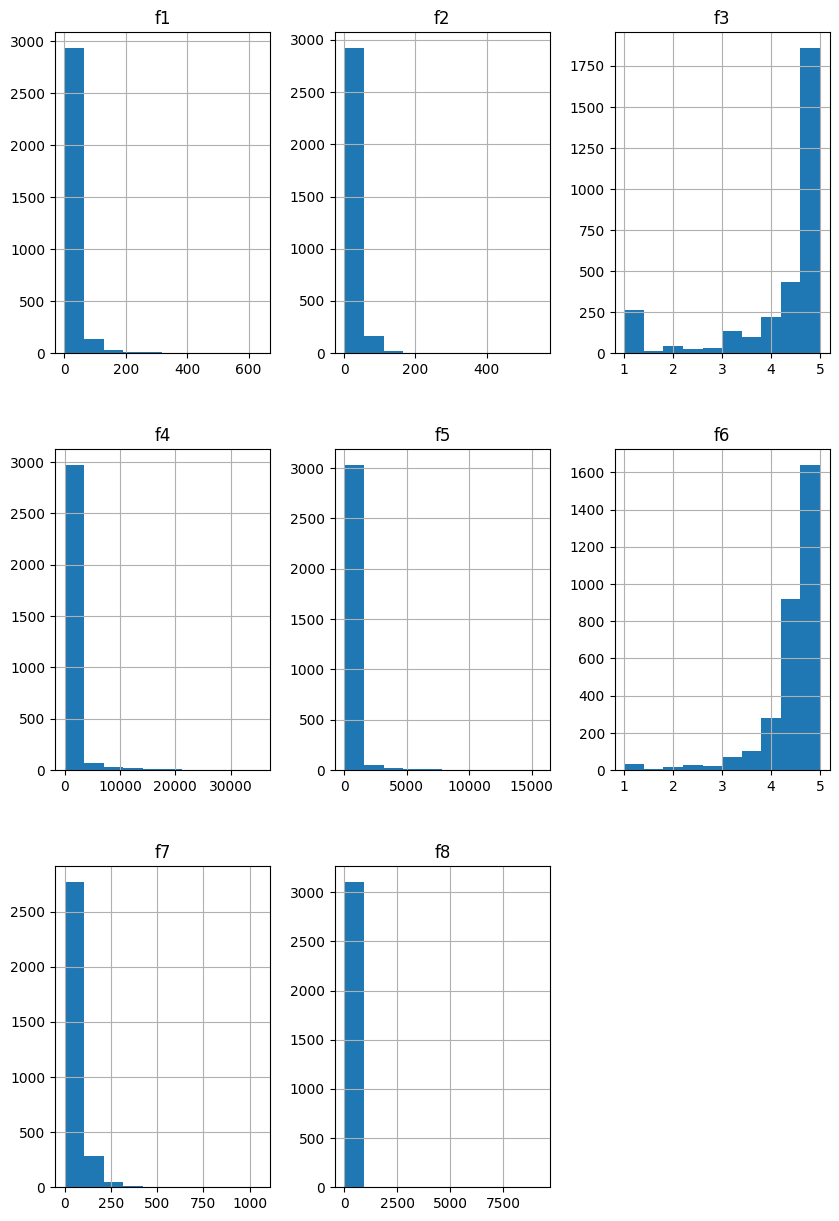

In [ ]:
df[['f1','f2','f3','f4','f5','f6','f7','f8']].hist(figsize=(10,15))

*Комментарий:* На основе EDA нельзя сделать вывод о том какие f-лучше всего оставить. Но на первый взгляд, кажется, что f6,f3 - является оценкой в чистом виде. Но также можно заметить много выбросов, от них нужно избавиться 

<Axes: >

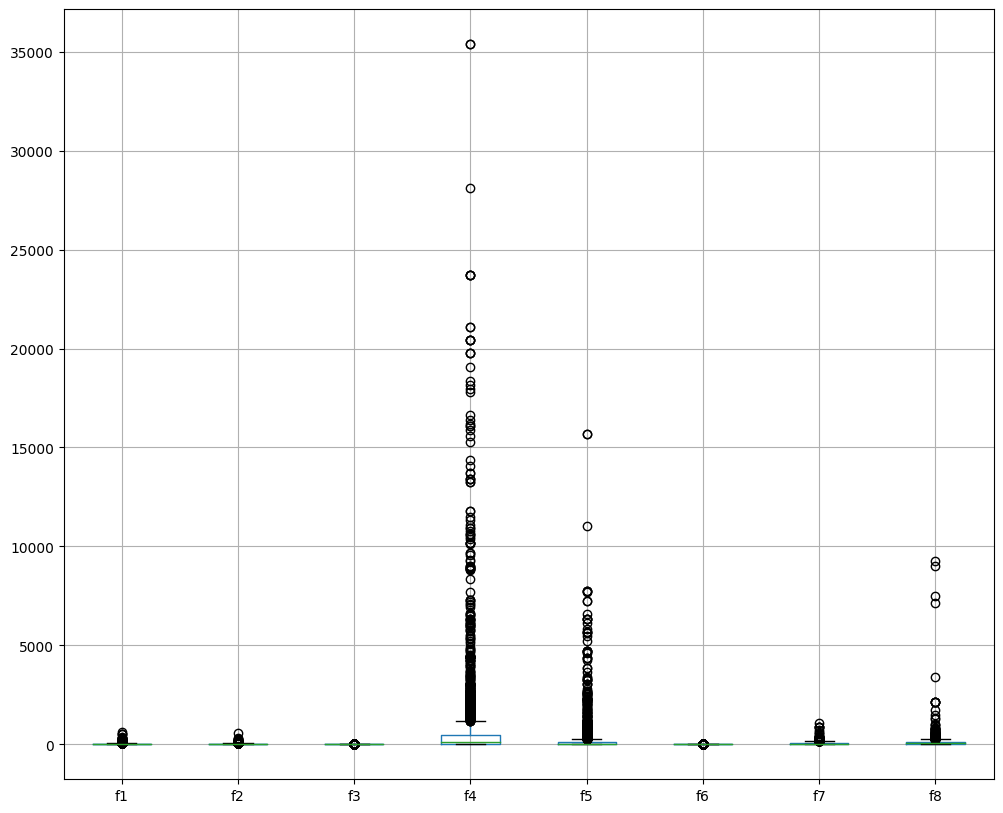

In [ ]:
df[['f1','f2','f3','f4','f5','f6','f7','f8']].boxplot(figsize=(12,10))

*Комментарий:* рассмотим каждую f,чтобы избавиться от выбрасов 